<a href="https://colab.research.google.com/github/teakrcmar/KPI-predictions/blob/main/prediction_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/teakrcmar/KPI-predictions.git

Cloning into 'KPI-predictions'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 23 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 2.75 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [5]:
df = pd.read_csv("KPI-predictions/Marketing.csv")

In [6]:
df.head()

,id,c_date,campaign_name,category,campaign_id,impressions,mark_spent,clicks,leads,orders,revenue
0,1,2021-02-01,facebook_tier1,social,349043,148263,7307.37,1210,13,1,4981.0
1,2,2021-02-01,facebOOK_tier2,social,348934,220688,16300.20,1640,48,3,14962.0
2,3,2021-02-01,google_hot,search,89459845,22850,5221.60,457,9,1,7981.0
3,4,2021-02-01,google_wide,search,127823,147038,6037.00,1196,24,1,2114.0
4,5,2021-02-01,youtube_blogger,influencer,10934,225800,29962.20,2258,49,10,84490.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             308 non-null    int64  
 1   c_date         308 non-null    object 
 2   campaign_name  308 non-null    object 
 3   category       308 non-null    object 
 4   campaign_id    308 non-null    int64  
 5   impressions    308 non-null    int64  
 6   mark_spent     308 non-null    float64
 7   clicks         308 non-null    int64  
 8   leads          308 non-null    int64  
 9   orders         308 non-null    int64  
 10  revenue        308 non-null    float64
dtypes: float64(2), int64(6), object(3)
memory usage: 26.6+ KB


In [ ]:
df.isnull().sum()
df.duplicated().sum()

0

In [9]:
# Get the total number of entries
total_entries = len(df)

# Calculate the indices for splitting
train_end = int(total_entries * 0.7)  # 70% for training
val_end = int(total_entries * 0.9)   # 20% for validation

# Split the dataset
train_set = df.iloc[:train_end]  # First 70%
val_set = df.iloc[train_end:val_end]  # Next 20%
test_set = df.iloc[val_end:]  # Last 10%

# Print the sizes of the splits
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 215
Validation set size: 62
Test set size: 31


In [10]:
# Calculate ROI
df['ROI'] = ((df['revenue'] - df['mark_spent']) / df['mark_spent']) * 100

# Calculate CPA_leads
df['CPA_leads'] = df['mark_spent'] / df['leads']

# Calculate CTR
df['CTR'] = (df['clicks'] / df['impressions']) * 100

# Calculate Conversion Rate from Clicks to Leads
df['Conversion_Rate_Clicks_Leads'] = (df['leads'] / df['clicks']) * 100

df['c_date'] = pd.to_datetime(df['c_date'])
df.set_index('c_date', inplace=True)

In [11]:
#Efficiency and Cost Analysis

# Cost Per Click (CPC)
df['CPC'] = df['mark_spent'] / df['clicks']
# Cost Per Thousand Impressions (CPM)
df['CPM'] = (df['mark_spent'] / df['impressions']) * 1000
# Average Order Value (AOV)
df['AOV'] = df['revenue'] / df['orders']
# Revenue Per Click (RPC)
df['RPC'] = df['revenue'] / df['clicks']

# Encode 'campaign_name' using LabelEncoder
label_encoder = LabelEncoder()
df['campaign_name'] = label_encoder.fit_transform(df['campaign_name'])

# Select relevant features
features = ['campaign_name', 'impressions', 'mark_spent', 'clicks', 'leads', 'orders']
target = 'revenue'

# Scale the data (features and target)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [12]:
def create_sequences(data, target_index, seq_length=10):
    """
    Create input-output pairs for time-series forecasting.
    - data: Scaled dataset (numpy array)
    - target_index: Index of the target variable in the data
    - seq_length: Number of time steps in each sequence
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1])  # Last 'seq_length' rows as features
        y.append(data[i, target_index])  # Target is the next value in the sequence
    return np.array(X), np.array(y)

# Sequence length: Use the last 'seq_length' days to predict the next day's revenue
seq_length = 10
X, y = create_sequences(scaled_data, target_index=-1, seq_length=seq_length)

# Split the data into training, validation, and test sets
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

In [13]:
# Define the GRU model
model1 = Sequential([
    GRU(64, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    GRU(32),
    Dense(1)  # Single output for revenue prediction
])

# Compile the model
model1.compile(optimizer='adam', loss='mse')

# Display the model architecture
model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          13,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,265 (90.88 KB)

 Trainable params: 23,265 (90.88 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#GRU model version 2

from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional

# Define the GRU model with more layers
model2 = Sequential([
    Bidirectional(GRU(128, return_sequences=True, input_shape=(seq_length, X_train.shape[2]))),  # Bidirectional GRU
    Dropout(0.2),  # Dropout layer for regularization
    GRU(64, return_sequences=True),  # Another GRU layer
    Dropout(0.2),  # Another Dropout
    GRU(32),  # Another GRU layer for more complexity
    Dropout(0.2),
    Dense(16, activation='relu'),  # Fully connected layer with ReLU activation
    Dense(1)  # Output layer for predicting revenue
])

model2.compile(optimizer='adam', loss='mse')

# Display the model architecture
model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Increased epochs
    batch_size=64,
    verbose=1
)

# Save the trained model
model1.save("gru_model_v2.h5")

# Evaluate the model on the test data
test_loss = model1.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions on the test data
y_test_pred = model1.predict(X_test)

# Reverse scale the predictions
padding = np.zeros((y_test_pred.shape[0], 1))  # Placeholder for one missing column

# Combine features and predictions for reverse scaling
y_test_pred_combined = np.hstack((X_test[:, -1, :-1], y_test_pred, padding))

# Reverse scale the predictions to actual revenue
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred_combined)[:, -2]  # Extract 'revenue' column

# Reverse scale the actual revenue
y_test_actual_combined = np.hstack((X_test[:, -1, :-1], y_test.reshape(-1, 1), padding))
y_test_actual_rescaled = scaler.inverse_transform(y_test_actual_combined)[:, -2]

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0179 - val_loss: 9.0868e-04
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0129 - val_loss: 0.0018
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0116 - val_loss: 8.7105e-04
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0114 - val_loss: 7.7262e-04
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0121 - val_loss: 6.4629e-04
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0100 - val_loss: 4.1015e-04
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0111 - val_loss: 4.9131e-04
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0139 - val_loss: 4.0660e-04
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0111 - val_loss: 4.7163e-04
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0098 - val_loss: 9.0086e-04
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0122 - val_loss: 8.8647e-04
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.5480e-04
Test Loss: 0.00035480092628858984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


Comparison of Predicted vs Actual Revenue (Test Set):
------------------------------------------------------------
Sample 1: Predicted Revenue = 0.49, Actual Revenue = 0.00
Sample 2: Predicted Revenue = 3.58, Actual Revenue = 0.00
Sample 3: Predicted Revenue = 9.09, Actual Revenue = 0.00
Sample 4: Predicted Revenue = 16.94, Actual Revenue = 3.14
Sample 5: Predicted Revenue = 0.42, Actual Revenue = 0.78
Sample 6: Predicted Revenue = -8.38, Actual Revenue = 0.00
Sample 7: Predicted Revenue = -12.44, Actual Revenue = 0.00
Sample 8: Predicted Revenue = 2.58, Actual Revenue = 0.00
Sample 9: Predicted Revenue = 8.80, Actual Revenue = 0.61
Sample 10: Predicted Revenue = -1.66, Actual Revenue = 0.52


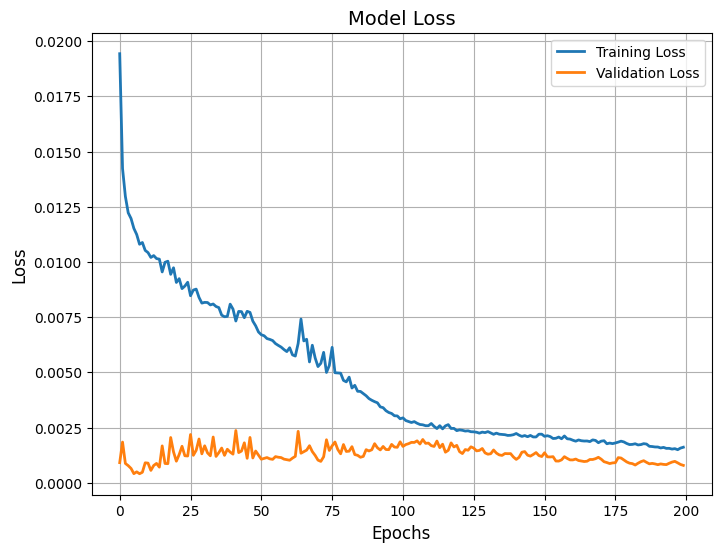

In [17]:
# Display the comparison for the first 10 samples
print("Comparison of Predicted vs Actual Revenue (Test Set):")
print("-" * 60)
for i in range(10):  # First 10 samples
    print(f"Sample {i+1}: Predicted Revenue = {y_test_pred_rescaled[i]:.2f}, "
          f"Actual Revenue = {y_test_actual_rescaled[i]:.2f}")

# Plot the training and validation loss
plt.figure(figsize=(8, 6))  # Set figure size for better visuals
plt.plot(history1.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)  # Add grid for better readability
plt.show()

In [18]:
# Print a summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 64)              │          13,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,797 (272.65 KB)

 Trainable params: 23,265 (90.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,532 (181.77 KB)

In [19]:
#GRU 2

# Train the model
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Increased epochs
    batch_size=64,
    verbose=1
)

# Save the trained model
model2.save("gru_model_v2.h5")

# Evaluate the model on the test data
test_loss = model2.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions on the test data
y_test_pred = model2.predict(X_test)

# Reverse scale the predictions
padding = np.zeros((y_test_pred.shape[0], 1))  # Placeholder for one missing column

# Combine features and predictions for reverse scaling
y_test_pred_combined = np.hstack((X_test[:, -1, :-1], y_test_pred, padding))

# Reverse scale the predictions to actual revenue
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred_combined)[:, -2]  # Extract 'revenue' column

# Reverse scale the actual revenue
y_test_actual_combined = np.hstack((X_test[:, -1, :-1], y_test.reshape(-1, 1), padding))
y_test_actual_rescaled = scaler.inverse_transform(y_test_actual_combined)[:, -2]

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - loss: 0.0153 - val_loss: 5.9405e-04
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0185 - val_loss: 5.6289e-04
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0117 - val_loss: 3.5243e-04
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0079 - val_loss: 0.0012
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0102 - val_loss: 0.0013
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0092 - val_loss: 3.5817e-04
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0131 - val_loss: 8.5211e-04
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0106 - val_loss: 3.8629e-04
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0097 - val_loss: 3.7781e-04
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0127 - val_loss: 8.2456e-04
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0131 - val_loss: 4.3802e-04
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.4818e-04
Test Loss: 0.00014817634655628353
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


Comparison of Predicted vs Actual Revenue (Test Set):
------------------------------------------------------------
Sample 1: Predicted Revenue = 10.55, Actual Revenue = 0.00
Sample 2: Predicted Revenue = 3.68, Actual Revenue = 0.00
Sample 3: Predicted Revenue = 2.31, Actual Revenue = 0.00
Sample 4: Predicted Revenue = 8.79, Actual Revenue = 3.14
Sample 5: Predicted Revenue = 3.55, Actual Revenue = 0.78
Sample 6: Predicted Revenue = 2.97, Actual Revenue = 0.00
Sample 7: Predicted Revenue = 0.46, Actual Revenue = 0.00
Sample 8: Predicted Revenue = 1.58, Actual Revenue = 0.00
Sample 9: Predicted Revenue = 4.00, Actual Revenue = 0.61
Sample 10: Predicted Revenue = 5.37, Actual Revenue = 0.52


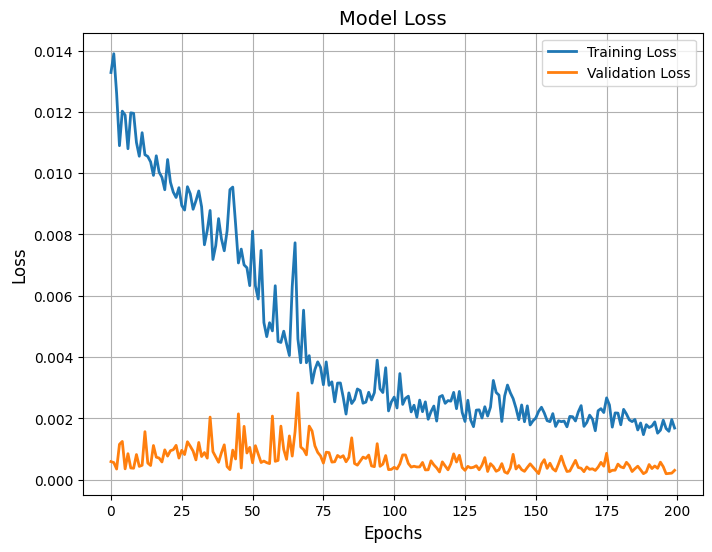

In [21]:
# Display the comparison for the first 10 samples
print("Comparison of Predicted vs Actual Revenue (Test Set):")
print("-" * 60)
for i in range(10):  # First 10 samples
    print(f"Sample {i+1}: Predicted Revenue = {y_test_pred_rescaled[i]:.2f}, "
          f"Actual Revenue = {y_test_actual_rescaled[i]:.2f}")

# Plot the training and validation loss
plt.figure(figsize=(8, 6))  # Set figure size for better visuals
plt.plot(history2.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history2.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)  # Add grid for better readability
plt.show()

In [22]:
# Print a summary of the model
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 10, 256)             │         104,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 10, 64)              │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,677 (2.02 MB)

 Trainable params: 176,225 (688.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 352,452 (1.34 MB)

In [23]:
# Evaluate Model 1 (GRU model 1)
test_loss_1 = model1.evaluate(X_test, y_test)
y_pred_1 = model1.predict(X_test)

# Evaluate Model 2 (GRU model 2)
test_loss_2 = model2.evaluate(X_test, y_test)
y_pred_2 = model2.predict(X_test)

print(f"Model 1 Test Loss: {test_loss_1}")
print(f"Model 2 Test Loss: {test_loss_2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.5480e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.4818e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Model 1 Test Loss: 0.00035480092628858984
Model 2 Test Loss: 0.00014817634655628353


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate RMSE and MAE for Model 1
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred_1))
mae_1 = mean_absolute_error(y_test, y_pred_1)
r2_1 = r2_score(y_test, y_pred_1)

# Calculate RMSE and MAE for Model 2
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))
mae_2 = mean_absolute_error(y_test, y_pred_2)
r2_2 = r2_score(y_test, y_pred_2)

# Print comparison metrics
print(f"Model 1 - RMSE: {rmse_1}, MAE: {mae_1}, R²: {r2_1}")
print(f"Model 2 - RMSE: {rmse_2}, MAE: {mae_2}, R²: {r2_2}")


Model 1 - RMSE: 0.018836160240651576, MAE: 0.01534460277165643, R²: -34.37913346882965
Model 2 - RMSE: 0.012172770596127837, MAE: 0.009865236581702222, R²: -13.775470324207179


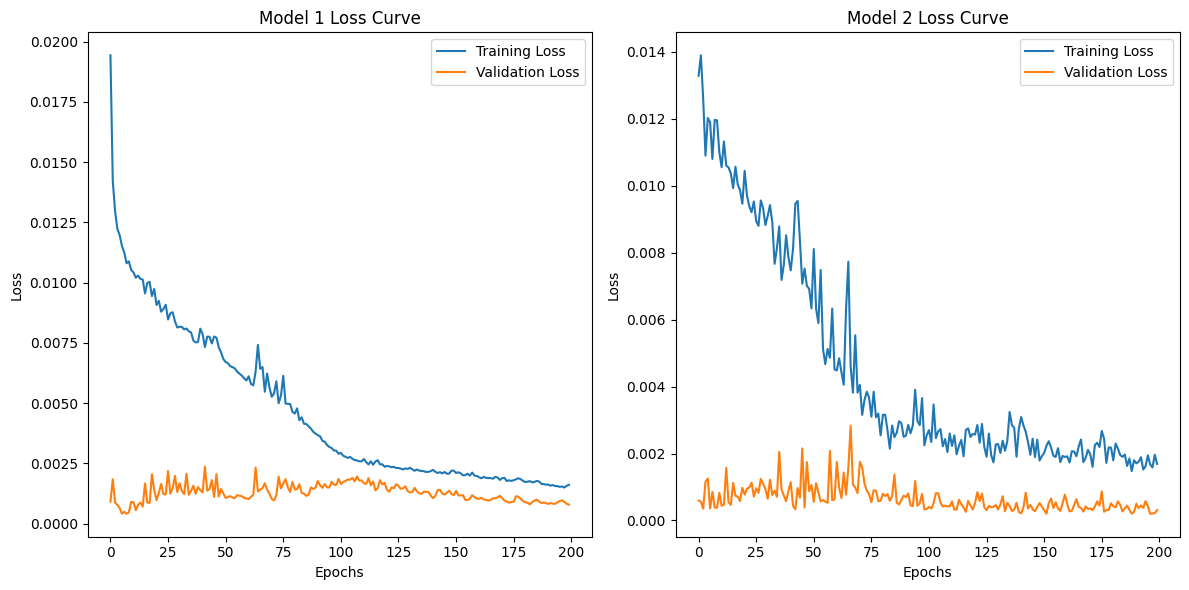

In [25]:
# Assuming you have the history for both models (e.g., history_1 and history_2)
plt.figure(figsize=(12, 6))

# Plot for Model 1
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Model 2
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


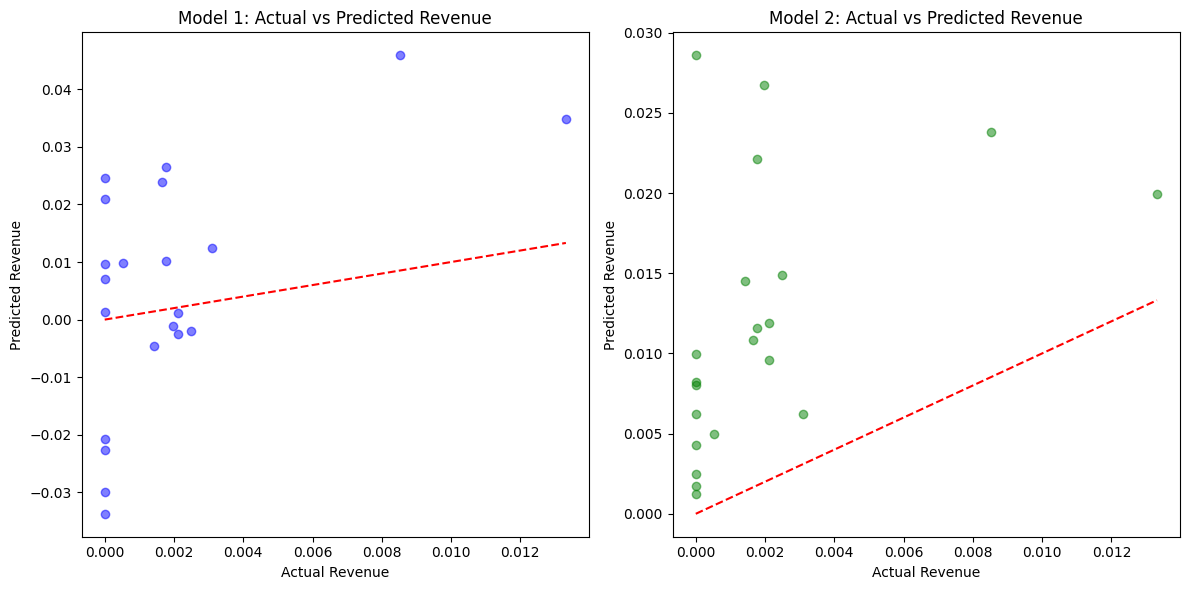

In [26]:
plt.figure(figsize=(12, 6))

# Plot for Model 1
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_1, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Model 1: Actual vs Predicted Revenue')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')

# Plot for Model 2
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_2, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Model 2: Actual vs Predicted Revenue')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')

plt.tight_layout()
plt.show()


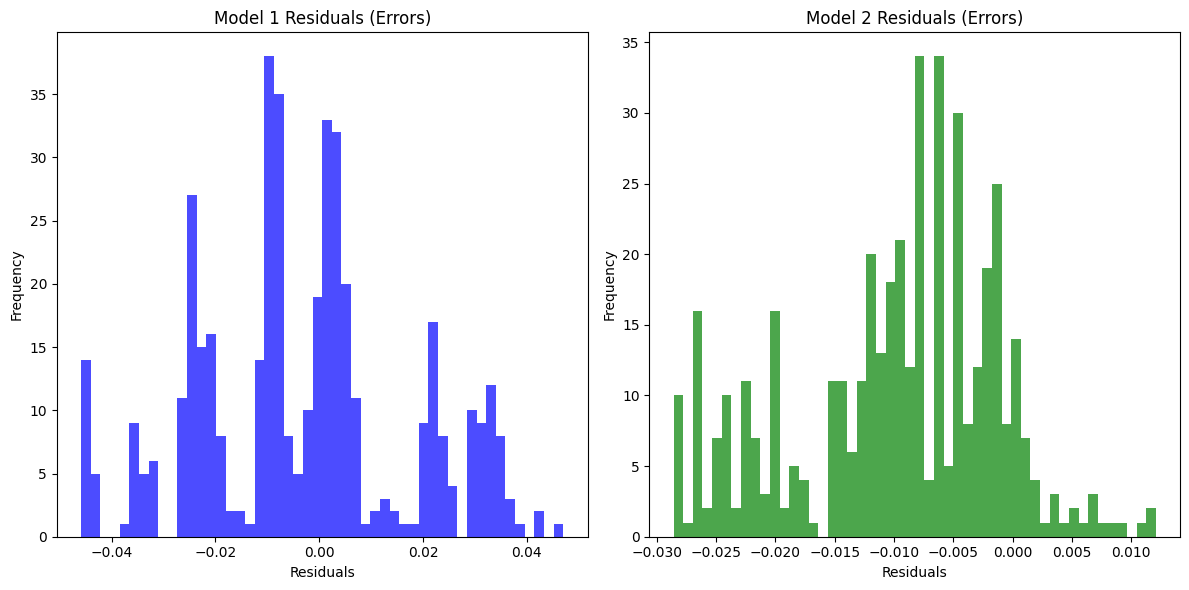

In [27]:
# Calculate residuals (errors) for both models
residuals_1 = y_test - y_pred_1
residuals_2 = y_test - y_pred_2

# Plot residuals (errors) for both models
plt.figure(figsize=(12, 6))

# Residuals for Model 1
plt.subplot(1, 2, 1)
plt.hist(residuals_1.flatten(), bins=50, color='blue', alpha=0.7)  # flatten the residuals if they're not 1D
plt.title('Model 1 Residuals (Errors)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Residuals for Model 2
plt.subplot(1, 2, 2)
plt.hist(residuals_2.flatten(), bins=50, color='green', alpha=0.7)  # flatten the residuals if they're not 1D
plt.title('Model 2 Residuals (Errors)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
